# Data Loading

In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer



# using the SQLite Table to read data.
con = sqlite3.connect('./amazon-fine-food-reviews/database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 




# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

# Data Cleaning

In [3]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)

#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

# Data Pre-processing

In [4]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    


6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [5]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [6]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [7]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

# Time Based Sorting

In [10]:
final=final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
scores = final['Score']

# Split the Data Set into train and test

In [11]:
# ============================== loading libraries ===========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.naive_bayes import BernoulliNB
import warnings
# =============================================================================================
#supress warnings
warnings.filterwarnings("ignore")

# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(final['CleanedText'].values, scores, test_size=0.3, random_state=0)

y_test = y_test.values
y_1 = y_1.values


# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)


# Converting Text to tfidfW2Vec

In [15]:
# Train your own Word2Vec model using X_tr
import gensim
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
i=0
list_of_sent_X_tr=[]
for sent in X_tr:
    sent = sent.decode('utf-8')
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_X_tr.append(filtered_sentence)

In [16]:
import gensim
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
i=0
list_of_sent_X_test=[]
for sent in X_test:
    sent = sent.decode('utf-8')
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_X_test.append(filtered_sentence)

In [17]:
import gensim
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
i=0
list_of_sent_X_cv=[]
for sent in X_cv:
    sent = sent.decode('utf-8')
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_X_cv.append(filtered_sentence)

In [18]:
w2v_model=gensim.models.Word2Vec(list_of_sent_X_tr,min_count=1,size=50, workers=4) 

In [19]:
tf_idf_X_tr_vect = TfidfVectorizer()
tf_idf_X_tr_vect.fit(X_tr)
final_tf_idf_X_tr_vect = tf_idf_X_tr_vect.transform(X_tr)
final_tf_idf_X_test_vect = tf_idf_X_tr_vect.transform(X_test)
final_tf_idf_X_cv_vect = tf_idf_X_tr_vect.transform(X_cv)

In [20]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_X_tr_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_X_tr_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_X_tr: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try: 
            
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf_X_tr_vect[row, tfidf_feat.index(word)]
            sent_vec +=(vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_X_tr_vectors.append(sent_vec)
    row += 1

In [21]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_X_tr_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_X_test_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_X_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf_X_test_vect[row, tfidf_feat.index(word)]
            sent_vec +=(vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_X_test_vectors.append(sent_vec)
    row += 1

In [22]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_X_tr_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_X_cv_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_X_cv: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf_X_cv_vect[row, tfidf_feat.index(word)]
            sent_vec +=(vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_X_cv_vectors.append(sent_vec)
    row += 1

In [23]:
from sklearn.preprocessing import Imputer
tfidf_sent_X_tr_vectors = Imputer().fit_transform(tfidf_sent_X_tr_vectors)
tfidf_sent_X_test_vectors = Imputer().fit_transform(tfidf_sent_X_test_vectors)
tfidf_sent_X_cv_vectors = Imputer().fit_transform(tfidf_sent_X_cv_vectors)

# CV Accuracy

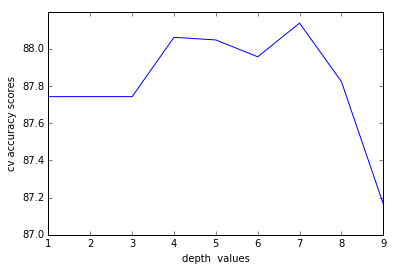

In [24]:
from sklearn import tree
cv_scores =[]
k_values = []
for i in range(1,10,1):
    # instantiate learning model (max_depth = 10)
    dt =tree.DecisionTreeClassifier(max_depth=i)
    
    # fitting the model on crossvalidation train
    dt.fit(tfidf_sent_X_tr_vectors, y_tr)

    # predict the response on the crossvalidation train
    pred = dt.predict(tfidf_sent_X_cv_vectors)

    # evaluate CV accuracy
    acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
    cv_scores.append(acc)
    k_values.append(i)
plt.plot(k_values, cv_scores)
plt.xlabel('depth  values')
plt.ylabel('cv accuracy scores')
plt.show()

#  Finding Optimal depth of tree


The optimal depth is 6.


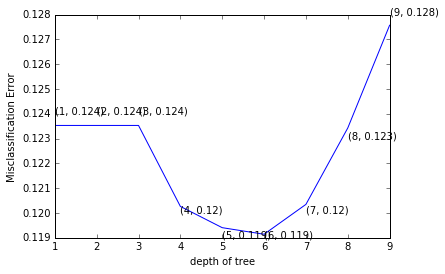

the misclassification error for each depth :  [0.124 0.124 0.124 0.12  0.119 0.119 0.12  0.123 0.128]


In [25]:
depth = list(range(1,10))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for i in depth:
    dt =tree.DecisionTreeClassifier(max_depth=i)
    scores = cross_val_score(dt, tfidf_sent_X_tr_vectors, y_tr, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best depth
optimal_depth = depth[MSE.index(min(MSE))]
print('\nThe optimal depth is %d.' % optimal_depth)

# plot misclassification error vs depth 
plt.plot(depth, MSE)

for xy in zip(depth, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('depth of tree')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each depth : ", np.round(MSE,3))

# CV Accuarcy

In [26]:
# ============================== DecisionTeeClasssifier with optimal_depth===============================================
# instantiate learning model eith optimal depth
dt_optimal = tree.DecisionTreeClassifier(max_depth=optimal_depth)

# fitting the model
dt_optimal.fit(tfidf_sent_X_tr_vectors, y_tr)

# predict the response on CV
pred = dt_optimal.predict(tfidf_sent_X_cv_vectors)

 # evaluate CV accuracy
acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
print('\nThe CV accuracy of the DecisionTreeClassifier for depth = %d is %f%%' % (optimal_depth, acc))


The CV accuracy of the DecisionTreeClassifier for depth = 6 is 87.957143%


# Train & Test Accuracy

In [27]:
# ============================== DecisionTeeClasssifier with optimal_depth===============================================
# instantiate learning model eith optimal depth
dt_optimal = tree.DecisionTreeClassifier(max_depth=optimal_depth)

# fitting the model
dt_optimal.fit(tfidf_sent_X_tr_vectors, y_tr)

# predict the response 
pred = dt_optimal.predict(tfidf_sent_X_test_vectors)

 # evaluate CV accuracy
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\nThe Test accuracy of the DecisionTreeClassifier for depth = %d is %f%%' % (optimal_depth, acc))
trainacc = dt_optimal.score(tfidf_sent_X_tr_vectors, y_tr)
print('\nThe Train accuracy of the DecisionTreeClassifier for depth = %d is %f%%' % (optimal_depth, trainacc*100))



The Test accuracy of the DecisionTreeClassifier for depth = 6 is 88.343333%

The Train accuracy of the DecisionTreeClassifier for depth = 6 is 88.518367%


# Important Features

In [30]:
importances = dt_optimal.feature_importances_
words = w2v_model.wv.index2word
imp = sorted(zip(importances, words),reverse=True)[:10]
for imortance,feature in imp:
    print(imortance,feature)

0.20901262132812226 want
0.18712687995195076 ive
0.17466390317068206 tea
0.17034163402225355 great
0.08420647303763637 product
0.04423683059797485 year
0.029606295608888784 price
0.01860694184425203 tri
0.013679139359441914 find
0.010520513956993906 well


# Conclusion

In [9]:
from prettytable import PrettyTable
t = PrettyTable()
t.field_names = ['Model', 'Hyperparameter','CV Error','Train Error','Test Error']
t.add_row(["DT using tfidfW2V vectorizer","6","0.12042857","0.11481633","0.11656667"])
print(t)

+------------------------------+----------------+------------+-------------+------------+
|            Model             | Hyperparameter |  CV Error  | Train Error | Test Error |
+------------------------------+----------------+------------+-------------+------------+
| DT using tfidfW2V vectorizer |       6        | 0.12042857 |  0.11481633 | 0.11656667 |
+------------------------------+----------------+------------+-------------+------------+
